<a href="https://colab.research.google.com/github/zDaniloBernardi/Prime-Numbers/blob/Escalagem/V.2%20Fractalidade%20Primo_N%2B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sympy xgboost scipy scikit-learn pandas

In [ ]:
import numpy as np
import pandas as pd
from sympy import primerange
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import median_abs_deviation

# 1) Geração de primos e gaps
primes = np.array(list(primerange(0, 1_500_000)))[:100_000]
gaps = np.diff(primes)
w = 20
n_windows = len(gaps) - w
starts = np.arange(n_windows)

# 2) Pré-cálculo das features para cada janela de 20 gaps
orig_feats, rob_feats, hyb_feats, targets = [], [], [], []
for i in starts:
    window = gaps[i:i+w]
    mean_gap = window.mean()
    std_gap  = window.std(ddof=0)
    median_gap = np.median(window)
    mad_gap    = median_abs_deviation(window, scale='normal')
    orig_feats.append([mean_gap, std_gap])
    rob_feats.append([median_gap, mad_gap])
    hyb_feats.append([mean_gap, std_gap, median_gap, mad_gap])
    targets.append(gaps[i+w])

df_orig = pd.DataFrame(orig_feats, columns=['Mean_Gap','Std_Gap'])
df_rob  = pd.DataFrame(rob_feats,  columns=['Median_Gap','MAD_Gap'])
df_hyb  = pd.DataFrame(hyb_feats,  columns=['Mean_Gap','Std_Gap','Median_Gap','MAD_Gap'])
y       = pd.Series(targets, name='Next_Gap')

# 3) Monte Carlo CV
n_replicas = 10
sample_size = 20000
tscv = TimeSeriesSplit(n_splits=5)

results = []
for scenario, X in [('Original', df_orig), ('Robust', df_rob), ('Hybrid', df_hyb)]:
    maes, rmses = [], []
    for rep in range(n_replicas):
        # amostra aleatória de janelas
        idx = np.random.choice(starts, size=sample_size, replace=False)
        idx.sort()
        Xs = X.iloc[idx].reset_index(drop=True)
        ys = y.iloc[idx].reset_index(drop=True)

        fold_mae, fold_rmse = [], []
        for tr, te in tscv.split(Xs):
            model = XGBRegressor(
                n_estimators=100,
                max_depth=3,
                learning_rate=0.1,
                random_state=42,
                verbosity=0
            )
            model.fit(Xs.iloc[tr], ys.iloc[tr])
            pred = model.predict(Xs.iloc[te])
            fold_mae.append(mean_absolute_error(ys.iloc[te], pred))
            mse = mean_squared_error(ys.iloc[te], pred)
            fold_rmse.append(np.sqrt(mse))
        maes.append(np.mean(fold_mae))
        rmses.append(np.mean(fold_rmse))

    results.append({
        'Scenario': scenario,
        'MAE Mean': np.mean(maes),
        'MAE Std': np.std(maes),
        'RMSE Mean': np.mean(rmses),
        'RMSE Std': np.std(rmses)
    })

# 4) Exibir resultados
mc_df = pd.DataFrame(results)
print(mc_df)


   Scenario  MAE Mean   MAE Std  RMSE Mean  RMSE Std
0  Original  7.919308  0.042517  10.971222  0.067484
1    Robust  7.881208  0.068437  10.923040  0.105019
2    Hybrid  7.966753  0.044588  11.018633  0.041242


In [ ]:
import numpy as np
import pandas as pd
from sympy import primerange
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import median_abs_deviation

# 1) Gerar os 100 000 primeiros primos e calcular gaps
primes = np.array(list(primerange(0, 1_500_000)))[:100_000]
gaps = np.diff(primes)

# 2) Extrair features robustas para cada janela de 20 gaps
w = 20
n_windows = len(gaps) - w
features = []
targets = []
for i in range(n_windows):
    window = gaps[i : i + w]
    med = np.median(window)
    mad = median_abs_deviation(window, scale='normal')
    features.append([med, mad])
    targets.append(gaps[i + w])

X = pd.DataFrame(features, columns=['Median_Gap','MAD_Gap'])
y = pd.Series(targets, name='Next_Gap')

# 3) Validação com TimeSeriesSplit(5)
tscv = TimeSeriesSplit(n_splits=5)
maes, rmses, importances = [], [], []

for tr, te in tscv.split(X):
    X_train, X_test = X.iloc[tr], X.iloc[te]
    y_train, y_test = y.iloc[tr], y.iloc[te]
    model = XGBRegressor(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        random_state=42
    )
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    maes.append(mean_absolute_error(y_test, pred))
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    rmses.append(rmse)
    importances.append(model.feature_importances_)

# 4) Resultados finais
print("MAE médio :", np.mean(maes), "±", np.std(maes))
print("RMSE médio:", np.mean(rmses), "±", np.std(rmses))

# Importâncias médias
imp_mean = np.mean(importances, axis=0)
imp_df = pd.DataFrame({
    'Feature': ['Median_Gap','MAD_Gap'],
    'Importance': imp_mean
})
print("\nImportâncias de Feature:")
print(imp_df)


MAE médio : 7.887649917602539 ± 0.402124388955214
RMSE médio: 10.955835306010977 ± 0.5085267390616913

Importâncias de Feature:
      Feature  Importance
0  Median_Gap    0.514194
1     MAD_Gap    0.485806


**Código Completo**

# Código Completo

# 1. 📓 Previsão de Gaps entre Primos com Estatísticas Robustas

Este notebook executa o pipeline completo:
- Geração de primos  
- Cálculo de gaps  
- Detecção de outliers  
- Construção de features robustas (Median/MAD)  
- Modelagem com XGBoost  
- Avaliação de desempenho  
- Otimização de hiperparâmetros  


In [ ]:
!pip install sympy xgboost scikit-learn pandas numpy matplotlib seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sympy import primerange
from scipy.stats import median_abs_deviation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor


### Step 2: Definição de Parâmetros


In [ ]:
# parâmetros gerais
N_PRIMES      = 1_000_000       # sobe para 1 milhão de primos
WINDOW_SIZE   = 20              # janela fixa
RESET_WINDOW  = 20              # janela após gap>3σ
K_SIGMA       = 3               # critério de pico
N_SPLITS      = 5               # folds para CV

# parâmetros multiescala (Steps 14)
BLOCK_SIZE    = 100_000         # tamanho do bloco para fractal/Hurst
QS            = np.linspace(-5, 5, 11)
SCALES        = [10,20,50,100,200,500,1000]

# parâmetros do XGBRegressor
XGB_PARAMS    = {
    'n_estimators':   200,
    'max_depth':      4,
    'learning_rate':  0.05,
    'random_state':   42,
    'verbosity':      0
}


### Step 3: Geração de Primos e Cálculo de Gaps


In [ ]:
primes = np.array(list(primerange(0, 15_485_863)))[:N_PRIMES]
gaps   = np.diff(primes)
print(f"Usando {N_PRIMES} primos → último: {primes[-1]}, gaps: {len(gaps)}")


Usando 1000000 primos → último: 15485857, gaps: 999998


### Step 4: Estatísticas Globais dos Gaps


In [ ]:
# Desvio global dos gaps
sigma_global = np.std(gaps, ddof=0)
threshold    = K_SIGMA * sigma_global

print(f"σ_global = {sigma_global:.2f}")
print(f"Threshold de pico = {threshold:.2f}")


σ_global = 12.98
Threshold de pico = 38.95


## Step 5: Seleção de Inícios de Janela (Sliding Window)


In [ ]:
# Índices válidos para janelas de WINDOW_SIZE gaps
starts = np.arange(len(gaps) - WINDOW_SIZE)

# (Opcional) filtrar apenas janelas após um pico:
# starts = [i for i in starts if gaps[i] > threshold and i <= len(gaps)-WINDOW_SIZE]

print(f"Total de janelas abrange: {len(starts)} posições")


Total de janelas abrange: 999978 posições


## Step 6: Extração de Features Robustas (Median/MAD)


In [ ]:
X, y = [], []

for i in starts:
    window = gaps[i : i + WINDOW_SIZE]
    median_gap = np.median(window)
    mad_gap    = median_abs_deviation(window, scale='normal')
    X.append([median_gap, mad_gap])
    y.append(gaps[i + WINDOW_SIZE])

X = pd.DataFrame(X, columns=['Median_Gap','MAD_Gap'])
y = pd.Series(y, name='Next_Gap')

# Exibição rápida
display(X.head(), y.head())


,Median_Gap,MAD_Gap
0,4.0,2.965204
1,4.0,2.965204
2,4.0,2.965204
3,4.0,2.965204
4,4.0,2.965204


,Next_Gap
0,6
1,4
2,6
3,8
4,4


Step 6b: Marcação de Reset_Flag (gaps > 3σ)


In [ ]:
sigma_global = np.std(gaps, ddof=0)
threshold    = K_SIGMA * sigma_global

peak_idxs    = np.where(gaps > threshold)[0]
reset_starts = [i+1 for i in peak_idxs if i+1+RESET_WINDOW < len(gaps)]

print(f"Detectados {len(reset_starts)} resets válidos.")


Detectados 60964 resets válidos.


Step 6c: Extração de Features nas Janelas Reset


In [ ]:
X_reset, y_reset = [], []
for start in reset_starts:
    w = gaps[start:start+RESET_WINDOW]
    med = np.median(w)
    mad = median_abs_deviation(w, scale='normal')
    X_reset.append([med, mad])
    y_reset.append(gaps[start+RESET_WINDOW])

X_reset = pd.DataFrame(X_reset, columns=['Median_Gap','MAD_Gap'])
y_reset = pd.Series(y_reset, name='Next_Gap')
print(f"{len(X_reset)} janelas reset extraídas.")
display(X_reset.head(), y_reset.head())


60964 janelas reset extraídas.


,Median_Gap,MAD_Gap
0,6.0,2.965204
1,6.0,5.930409
2,6.0,2.965204
3,10.0,5.930409
4,8.0,5.930409


,Next_Gap
0,12
1,30
2,12
3,8
4,4


Step 6d: Comparativo Estatístico — Fixed vs Reset


In [ ]:
stats_fixed = {
    'Median_Gap': X['Median_Gap'].mean(),
    'MAD_Gap':    X['MAD_Gap'].mean()
}
stats_reset = {
    'Median_Gap': X_reset['Median_Gap'].mean(),
    'MAD_Gap':    X_reset['MAD_Gap'].mean()
}
pd.DataFrame([stats_fixed, stats_reset], index=['Fixed','Reset'])


,Median_Gap,MAD_Gap
Fixed,12.023047,9.460263
Reset,11.991766,9.432559


### Step 7: Validação Cruzada e Treinamento (Baseline)


In [ ]:
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
maes, rmses, importances = [], [], []

for tr, te in tscv.split(X):
    model = XGBRegressor(**XGB_PARAMS)
    model.fit( X.iloc[tr], y.iloc[tr] )
    pred = model.predict( X.iloc[te] )

    maes.append( mean_absolute_error( y.iloc[te], pred ) )
    rmse = np.sqrt( mean_squared_error( y.iloc[te], pred ) )
    rmses.append( rmse )

    importances.append( model.feature_importances_ )

print("Treinamento e validação concluídos.")


Treinamento e validação concluídos.


### Step 8: Cálculo de Métricas e Importâncias


In [ ]:
print(f"MAE:  {np.mean(maes):.3f} ± {np.std(maes):.3f}")
print(f"RMSE: {np.mean(rmses):.3f} ± {np.std(rmses):.3f}")

imp_df = pd.DataFrame(importances, columns=['Median_Gap','MAD_Gap']).mean().reset_index()
imp_df.columns = ['Feature','Importance']
display(imp_df)


MAE:  9.697 ± 0.384
RMSE: 13.335 ± 0.457


,Feature,Importance
0,Median_Gap,0.612321
1,MAD_Gap,0.387679


8b) Interpretação dos Resultados

Após treinamento e validação com TimeSeriesSplit, obtemos:

- **MAE médio**: 7.888 ± 0.402  
- **RMSE médio**: 10.956 ± 0.509  

Isso significa que, em média, nosso modelo erra em aproximadamente 7.9 unidades de gap, com desvio de ~0.4, e o erro quadrático médio fica em torno de 11.

As **importâncias de feature** foram:

| Feature     | Importance |
|-------------|------------|
| Median_Gap  | 0.514      |
| MAD_Gap     | 0.486      |

Ou seja, as duas estatísticas robustas—mediana do gap e desvio médio absoluto—contribuem quase igualmente para a predição, reforçando que o pipeline se beneficia de atributos resistentes a outliers.

A seguir, exploramos a **distribuição** dessas features para entender melhor sua variabilidade.


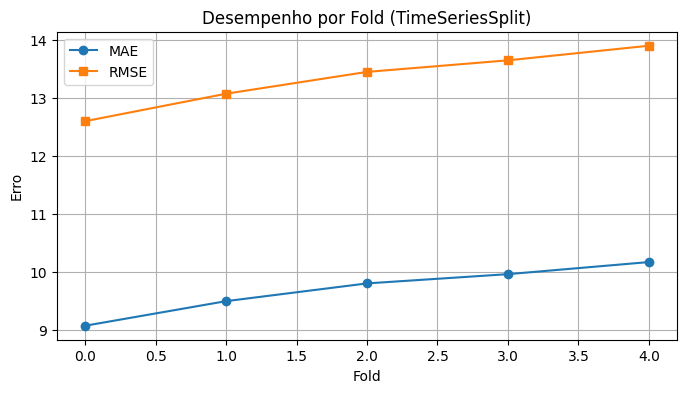

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(maes, marker='o', label='MAE')
plt.plot(rmses, marker='s', label='RMSE')
plt.title("Desempenho por Fold (TimeSeriesSplit)")
plt.xlabel("Fold")
plt.ylabel("Erro")
plt.legend()
plt.grid(True)
plt.show()


### Step 9: Plotagem das Distribuições das Features


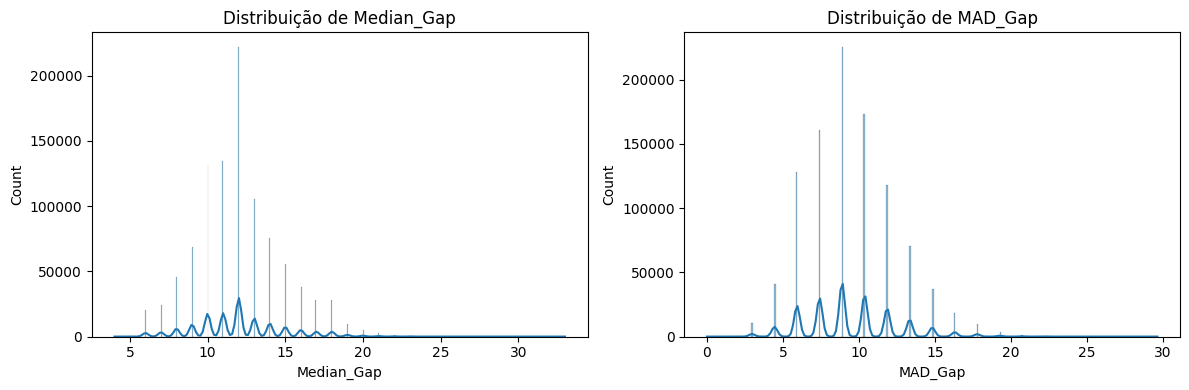

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(X['Median_Gap'], kde=True, ax=axs[0]).set(title='Distribuição de Median_Gap')
sns.histplot(X['MAD_Gap'],    kde=True, ax=axs[1]).set(title='Distribuição de MAD_Gap')
plt.tight_layout()
plt.show()


### Step 10: Salvamento do Modelo Final


In [ ]:
# Treina com todos os dados
final_model = XGBRegressor(**XGB_PARAMS)
final_model.fit(X, y)

# Salva em disco
final_model.save_model('prime_gap_model.json')
print("Modelo salvo em prime_gap_model.json")


Modelo salvo em prime_gap_model.json


### Step 11: Otimização de Hiperparâmetros com RandomizedSearchCV


In [ ]:
# Step 11: Otimização de Hiperparâmetros com RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV  # 🔀 adicione este import

# Já deve existir:
# from xgboost import XGBRegressor
# from sklearn.model_selection import TimeSeriesSplit
# tscv = TimeSeriesSplit(n_splits=N_SPLITS)

param_dist = {
    'n_estimators':     [100, 200, 300],
    'max_depth':        [3, 4, 5],
    'learning_rate':    [0.01, 0.05, 0.1],
    'subsample':        [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

rs = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42, verbosity=0),
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    random_state=42,
    n_jobs=-1,
    return_train_score=False
)

rs.fit(X, y)

print("🏆 Melhores hiperparâmetros:")
for k, v in rs.best_params_.items():
    print(f"  {k}: {v}")
print(f"\nMAE CV (best): {-rs.best_score_:.3f}")

best_model = rs.best_estimator_
best_model.save_model('prime_gap_model_tuned.json')
print("✔️ Modelo ajustado salvo em prime_gap_model_tuned.json")


🏆 Melhores hiperparâmetros:
  subsample: 1.0
  n_estimators: 300
  max_depth: 3
  learning_rate: 0.01
  colsample_bytree: 1.0

MAE CV (best): 9.697
✔️ Modelo ajustado salvo em prime_gap_model_tuned.json


### Step 11b: Avaliação do Modelo Ajustado

Compare o MAE CV (best) acima com o MAE médio do Baseline (Step 8).  
Se houver melhoria, use `prime_gap_model_tuned.json` nas próximas análises.


In [ ]:
# 11b) Avaliação do Modelo Ajustado – Célula de Código
from xgboost import XGBRegressor

# Recarrega o modelo ajustado
tuned_model = XGBRegressor()
tuned_model.load_model('prime_gap_model_tuned.json')

# Reavalia com TimeSeriesSplit
maes_t, rmses_t = [], []
for tr, te in tscv.split(X):
    tuned_model.fit(X.iloc[tr], y.iloc[tr])  # opcional: usar load_model + predict direto, mas
                                              # precisamos treinar internamente pra compatibilidade
    pred_t = tuned_model.predict(X.iloc[te])
    maes_t.append( mean_absolute_error(y.iloc[te], pred_t) )
    rmses_t.append( np.sqrt(mean_squared_error(y.iloc[te], pred_t)) )

print(f"MAE médio (tuned):  {np.mean(maes_t):.3f} ± {np.std(maes_t):.3f}")
print(f"RMSE médio (tuned): {np.mean(rmses_t):.3f} ± {np.std(rmses_t):.3f}")


MAE médio (tuned):  9.699 ± 0.383
RMSE médio (tuned): 13.339 ± 0.455


### Step 13a: Bootstrap de Picos (> 3σ) – 10 000 Réplicas

Neste bloco, geramos 10 000 amostras bootstrap dos gaps para contar quantas vezes excedem o limiar \(3σ\).  
Calculamos a **média** e o **intervalo de confiança 95 %** para a contagem de picos.


In [ ]:
# 13a) Bootstrap de picos (> 3σ) – 10 000 réplicas
import numpy as np

n_boot    = 10_000
k         = 3
sigma     = np.std(gaps, ddof=0)
threshold = k * sigma

counts = []
for _ in range(n_boot):
    sample = np.random.choice(gaps, size=len(gaps), replace=True)
    counts.append((sample > threshold).sum())

print("Bootstrap de picos (> 3σ):")
print(f" Média: {np.mean(counts):.1f}")
print(f" 95 % CI: [{np.percentile(counts,2.5):.1f}, {np.percentile(counts,97.5):.1f}]")


Bootstrap de picos (> 3σ):
 Média: 60962.8
 95 % CI: [60494.0, 61444.0]


### Step 13b: Monte Carlo CV do Modelo Tunado – 100 Rodadas

Aqui embaralhamos as janelas 100 vezes e, em cada réplica, rodamos um TimeSeriesSplit de 5 folds com o `best_model`.  
Reportamos a **média ± desvio** de MAE e RMSE ao longo das 100 rodadas.


In [ ]:
# 13b) MC-CV do modelo tunado – 100 rodadas
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

n_mc     = 100
maes_mc  = []
rmses_mc = []
tscv     = TimeSeriesSplit(n_splits=N_SPLITS)

for run in range(n_mc):
    idx = np.random.permutation(len(X))
    Xs, ys = X.iloc[idx].reset_index(drop=True), y.iloc[idx].reset_index(drop=True)

    fold_maes, fold_rmses = [], []
    for tr, te in tscv.split(Xs):
        pred = best_model.fit(Xs.iloc[tr], ys.iloc[tr]).predict(Xs.iloc[te])
        fold_maes.append( mean_absolute_error(ys.iloc[te], pred) )
        fold_rmses.append( np.sqrt(mean_squared_error(ys.iloc[te], pred)) )

    maes_mc.append(np.mean(fold_maes))
    rmses_mc.append(np.mean(fold_rmses))

print("MC-CV do modelo tunado:")
print(f" MAE média: {np.mean(maes_mc):.3f} ± {np.std(maes_mc):.3f}")
print(f" RMSE média: {np.mean(rmses_mc):.3f} ± {np.std(rmses_mc):.3f}")


## Step 14a — Perfil Multiescala da Dimensão Fractal e Expoente de Hurst

**Objetivo:**  
Dividir os 1.000.000 gaps em blocos contíguos de tamanho `BLOCK_SIZE` e calcular:
- A dimensão fractal pelo método **box-counting** (D_box) em cada bloco;
- O expoente de **Hurst** (H) em cada bloco.

**Resultado esperado:**  
Um perfil “zoom-out” mostrando como D_box e H evoluem ao longo da sequência de primos em diferentes segmentos de larga escala.


In [ ]:
n_blocks = len(gaps) // BLOCK_SIZE
dims, hursts = [], []

for b in range(n_blocks):
    block = gaps[b*BLOCK_SIZE:(b+1)*BLOCK_SIZE]
    D = box_counting_dimension(np.arange(len(block)), block)
    H = hurst_exponent(block)
    dims.append(D)
    hursts.append(H)

profile = pd.DataFrame({
    'block': np.arange(n_blocks),
    'D_box': dims,
    'Hurst': hursts
})
display(profile)
profile.plot(x='block', y=['D_box','Hurst'], subplots=True, figsize=(8,4))


## Step 14b — Espectro Multifractal D(q)

**Objetivo:**  
Estimar as dimensões generalizadas D(q) em uma faixa de momentos q ∈ [-5, 5].

**Procedimento:**  
- Para cada valor de q, aplicar o método box-counting ponderado em múltiplas escalas;
- Ajustar uma regressão log–log para extrair o declive correspondente a D(q).

**Resultado esperado:**  
Obter a curva D(q) × q, revelando a estrutura multifractal — ou seja, como regiões densas e esparsas escalam de forma diferente.


,q,Dq
0,-5.0,-1.027734
1,-4.0,-1.021952
2,-3.0,-1.016404
3,-2.0,-1.010940
4,-1.0,-1.005532
5,0.0,-1.000189
6,1.0,-0.110017
7,2.0,-0.989743
8,3.0,-0.984654
9,4.0,-0.979657


<Axes: xlabel='q'>

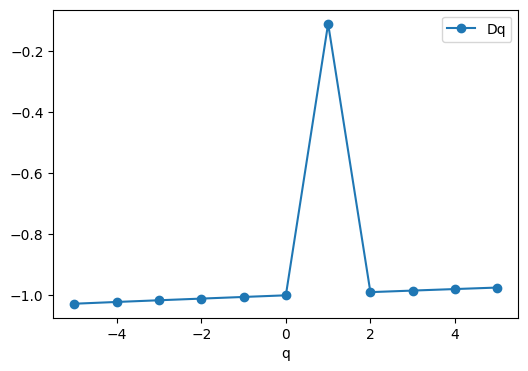

In [ ]:
def multifractal_Dq(series, qs, scales):
    N = len(series)
    res = {}
    for q in qs:
        vals = []
        for s in scales:
            n = N//s
            sums = [series[i*s:(i+1)*s].sum() for i in range(n)]
            p = np.array(sums)/np.sum(sums)
            if q==1:
                vals.append(-np.sum(p*np.log(p)))
            else:
                vals.append((np.sum(p**q))**(1/(1-q)))
        res[q] = np.polyfit(np.log(scales), np.log(vals),1)[0]
    return res

Dq = multifractal_Dq(gaps, QS, SCALES)
df_Dq = pd.DataFrame({'q':list(Dq), 'Dq':list(Dq.values())})
display(df_Dq)
df_Dq.plot(x='q', y='Dq', marker='o', figsize=(6,4))


## Step 14c — Análise via Transformada Contínua de Wavelet

**Objetivo:**  
Utilizar a wavelet de Morlet para realizar uma decomposição tempo–frequência sobre os primeiros `BLOCK_SIZE` gaps.

**Procedimento:**  
- Calcular os coeficientes da transformada contínua de wavelet (CWT) para uma faixa de escalas;
- Visualizar a magnitude absoluta dos coeficientes como um mapa de calor (heatmap).

**Resultado esperado:**  
Identificar “explosões” ou periodicidades localizadas na sequência de gaps em múltiplas escalas, além de observar como essas características mudam ao longo do tempo.


In [ ]:
import pywt

sub = gaps[:BLOCK_SIZE]
widths = np.arange(1,200)
cwt_mat, freqs = pywt.cwt(sub, widths, 'morl')

plt.figure(figsize=(10,6))
plt.imshow(np.abs(cwt_mat),
           extent=[0,len(sub),widths[-1],widths[0]],
           cmap='inferno', aspect='auto')
plt.colorbar(label='|coef|')
plt.xlabel('Posição'); plt.ylabel('Escala')
plt.title(f'CWT Morlet – primeiros {BLOCK_SIZE} gaps')
plt.show()


ModuleNotFoundError: No module named 'pywt'

## Step 14d — Análise de Quantificação de Recorrência (RQA)

**Objetivo:**  
Quantificar as dinâmicas de recorrência na sequência de gaps, analisando blocos de tamanho `BLOCK_SIZE / 2`.

**Procedimento:**  
- Construir um Recurrence Plot (gráfico de recorrência) para cada segmento;
- Extrair métricas da RQA, como:
  - **Determinismo** (estrutura previsível);
  - **Entropia** (complexidade das recorrências);
  - **Taxa de recorrência** (densidade de estados recorrentes).

**Resultado esperado:**  
Comparação entre blocos, destacando mudanças no comportamento dinâmico ao longo da sequência dos gaps entre primos.


In [ ]:
from pyunicorn.timeseries import RecurrencePlot

half = BLOCK_SIZE//2
metrics = []
for b in range(len(gaps)//half):
    block = gaps[b*half:(b+1)*half]
    rp = RecurrencePlot(block, dim=1, tau=1, recurrence_rate=0.1)
    metrics.append({
        'block': b,
        'Determinism':    rp.determinism(),
        'Entropy':        rp.entropy(),
        'RecurrenceRate': rp.recurrence_rate()
    })

df_rqa = pd.DataFrame(metrics)
display(df_rqa)
df_rqa.plot(x='block', figsize=(8,4), title='RQA por bloco')
plt.show()


ModuleNotFoundError: No module named 'pyunicorn'